# Objective:- To optimize network resource utilization in 5G network when allocating network slices to different types of usecases 

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.model_selection import KFold
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SelectKBest # for best feature selection
from sklearn.feature_selection import f_classif # for ANOVA statistical method

In [2]:
df = pd.read_csv('kpi_input_data_final.csv')
df_pred=pd.read_csv('predict_data_update.csv')

In [3]:
# Model configuration
batch_size = 128
loss_function = categorical_crossentropy
no_classes = 3
no_epochs = 15
optimizer = Adam()
verbosity = 1
num_folds = 5
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []


In [4]:
# Change the column names with reference to Deepslice _Model_Data_Publci_File
df.columns =['Use CaseType (Input 1)', 'LTE/5G UE Category (Input 2)','Technology Supported (Input 3)','Day (Input4)','Time (Input 5)','GBR (Input 6)','Packet Loss Rate (Reliability)(Input 7)','Packet Delay Budget (Latency)(Input 8)','Slice Type (Output)']
df_pred.columns =['Use CaseType (Input 1)', 'LTE/5G UE Category (Input 2)','Technology Supported (Input 3)','Day (Input4)','Time (Input 5)','GBR (Input 6)','Packet Loss Rate (Reliability)(Input 7)','Packet Delay Budget (Latency)(Input 8)','Slice Type (Output)']
  

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63167 entries, 0 to 63166
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Use CaseType (Input 1)                   63167 non-null  int64
 1   LTE/5G UE Category (Input 2)             63167 non-null  int64
 2   Technology Supported (Input 3)           63167 non-null  int64
 3   Day (Input4)                             63167 non-null  int64
 4   Time (Input 5)                           63167 non-null  int64
 5   GBR (Input 6)                            63167 non-null  int64
 6   Packet Loss Rate (Reliability)(Input 7)  63167 non-null  int64
 7   Packet Delay Budget (Latency)(Input 8)   63167 non-null  int64
 8   Slice Type (Output)                      63167 non-null  int64
dtypes: int64(9)
memory usage: 4.3 MB


In [6]:
df.shape

(63167, 9)

In [7]:
# Dependent or Output variable 
slice_class=df['Slice Type (Output)'].unique() 
slice_class

array([2, 3, 1], dtype=int64)

In [8]:
# Correlation between Variables/Features 
corr = df.corr()

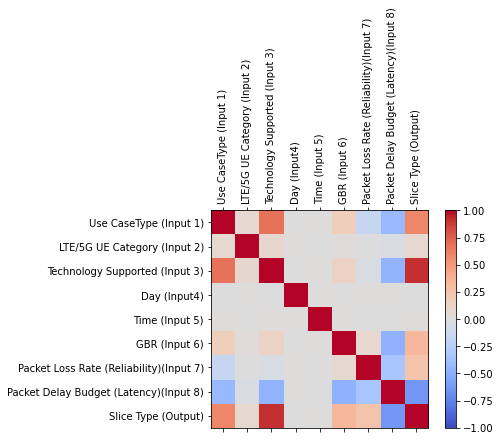

In [9]:
# Plot Correlation between Variables/Features 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [10]:
# Mean of the features
df.groupby('Slice Type (Output)').mean()

,Use CaseType (Input 1),LTE/5G UE Category (Input 2),Technology Supported (Input 3),Day (Input4),Time (Input 5),GBR (Input 6),Packet Loss Rate (Reliability)(Input 7),Packet Delay Budget (Latency)(Input 8)
Slice Type (Output),,,,,,,,
1,1.800000,10.500000,1.0,4.000000,11.50000,1.500000,2.200000,4.900000
2,5.499831,11.500169,2.0,3.999797,11.50044,1.249949,1.250017,4.500169
3,5.000000,11.500000,2.0,4.000000,11.50000,2.000000,3.000000,1.000000


In [11]:
# X1 and Y1 are pd dataframe (as we need the columns of pd and X and Y are numpy arrays-(because .values convert it into nupy array) those dont have columns attributes like X1.columns )
X_train = df.iloc[:,:-1]
Y_train = df.iloc[:,-1]
XT=df_pred.iloc[:,:-1] # for prediction X
YT=df_pred.iloc[:,-1]  # for prediction Y    

In [12]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info=mutual_info_classif(X_train,Y_train)
mutual_info

array([9.36422561e-01, 2.74256656e-02, 6.94966034e-01, 4.76955904e-04,
       0.00000000e+00, 1.86783587e-01, 3.82119432e-01, 7.57283769e-01])

In [13]:
mutual_info=pd.Series(mutual_info)
mutual_info.index=X_train.columns 
mutual_info.sort_values(ascending=False)

Use CaseType (Input 1)                     0.936423
Packet Delay Budget (Latency)(Input 8)     0.757284
Technology Supported (Input 3)             0.694966
Packet Loss Rate (Reliability)(Input 7)    0.382119
GBR (Input 6)                              0.186784
LTE/5G UE Category (Input 2)               0.027426
Day (Input4)                               0.000477
Time (Input 5)                             0.000000
dtype: float64

<AxesSubplot:>

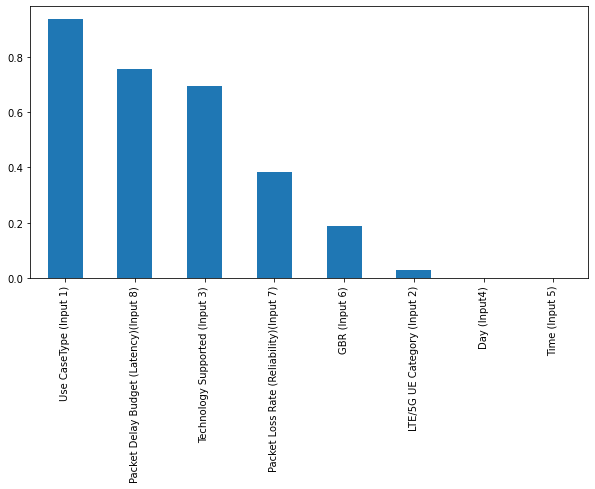

In [14]:
# lets plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10,5))

In [15]:
# define feature selection
# Now we will select the top 4 important features
sel_three_cols=SelectKBest(mutual_info_classif,k=4)
sel_three_cols.fit(X_train,Y_train)
X_train_sel=X_train.columns[sel_three_cols.get_support()]
X_train_sel=sel_three_cols.transform(X_train)
XT_sel=sel_three_cols.transform(XT)
#X=X_top_3_features
#XT=XT_top_3_features

In [16]:
X_train_sel.shape,XT_sel.shape

((63167, 4), (253, 4))

In [17]:
### top_three_columns=['Use CaseType (Input 1)', 'Technology Supported (Input 3)','Packet Delay Budget (Latency)(Input 8)']

In [18]:

Y_train = Y_train.values  # for model creation - Y

YT=YT.values   # for prediction Y     

LabelEncoder used to normalize labels of Output variable Y
Encode target labels with value between 0 and n_classes-1.
This transformer should be used to encode target values, i.e. y, and not the input X.
encoding technique for handling categorical variables. In this technique, each label is assigned a unique integer based on alphabetical ordering

In [19]:

encoder = LabelEncoder()
encoder.fit(Y_train) # Fit label encoder and it found the LE classes or labels
encoded_Y = encoder.transform(Y_train).astype(np.int32) # Transform labels to normalized encoding.

In [20]:
encoded_Y

array([1, 1, 1, ..., 0, 0, 0])


Converts a class vector (integers) to binary class matrix.
E.g. with categorical_crossentropy.
Args:
    y: Array-like with class values to be converted into a matrix
        (integers from 0 to num_classes - 1).
Returns:
    A binary matrix representation of the input. The class axis is placed last.

In [21]:
encoded_Y=encoded_Y.reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(encoded_Y),enc.categories_

(OneHotEncoder(handle_unknown='ignore'), [array([0, 1, 2])])

In [22]:
dummy_y=enc.transform(encoded_Y).toarray()
dummy_y.shape

(63167, 3)

In [23]:
# Split the data up in train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(X_train_sel, dummy_y, test_size=0.20, random_state=1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


In [24]:
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 50533
No. of testing examples: 12634


The ReLU (Rectified Linear Unit) is the go-to function for many neural networks since it is cheap to compute and still works well enough for many applications.
It is a non-linear function that gives the same output as input if the input is above 0, otherwise the output will be 0. that is,
Output = input, if input is above 0
Output = 0, if input is below 0
The ReLU function also helps with the problem of vanishing gradients in deep networks by not squashing in both ends.
f(x) = max(x, 0);


In [25]:

from time import time
# starting time
start = time()


# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
#scores = []
histories = []
for train, test in kfold.split(X_train, y_train):
  
  # Define the model architecture
  # # Initialize the constructor - Create Model
  model=Sequential()
  # Add an input layer 
  model.add(Dense(input_dim=4,
                units=8, activation='relu',name="HiddenLayer1-ReLu"))
  # Add hidden layer 1
  model.add(Dense(units=4, activation='tanh', name="HiddenLayer2-Tanh"))
  # Add hidden layer 2
  model.add(Dense(units=3, activation='relu', name="HiddenLayer3-ReLu"))
  # Add output layer 
  model.add(Dense(no_classes, activation='softmax',name="OutputLayer-SoftMax"))
  
  # Compile model
  model.compile(loss=loss_function, 
                optimizer=optimizer,
                metrics=['accuracy'])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  # Fit the model
  histories.append(model.fit(X_train, y_train, 
                      validation_split=0.3, 
                      epochs=no_epochs, 
                      batch_size=batch_size))
  # Evaluate the model - Generate generalization metrics
  scores =model.evaluate(X_test, y_test,verbose=2)
  print(f'\nTest Accuracy :- Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

# end time
#end = time.time()


# total time taken
print('------------------------------------------------------------------------')
print(f'\nTime taken to run: {time() - start} seconds') 


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')  

#print(model.summary())

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
277/277 [==============================] - 1s 2ms/step - loss: 0.7890 - accuracy: 0.6839 - val_loss: 0.5584 - val_accuracy: 0.7661
Epoch 2/15
277/277 [==============================] - 1s 2ms/step - loss: 0.4802 - accuracy: 0.8497 - val_loss: 0.4267 - val_accuracy: 0.8845
Epoch 3/15
277/277 [==============================] - 1s 2ms/step - loss: 0.3968 - accuracy: 0.8831 - val_loss: 0.3684 - val_accuracy: 0.8845
Epoch 4/15
277/277 [==============================] - 1s 2ms/step - loss: 0.3521 - accuracy: 0.8831 - val_loss: 0.3355 - val_accuracy: 0.8845
Epoch 5/15
277/277 [==============================] - 1s 2ms/step - loss: 0.3293 - accuracy: 0.8831 - val_loss: 0.3204 - val_accuracy: 0.8845
Epoch 6/15
277/277 [==============================] - 1s 2ms/step - loss: 0.3188 - accuracy: 0.8831 - val_loss: 0.3134 - val_accuracy: 0.8845
Epoch 7/15
277/277 [==============================]

The evaluate() function will return a list with two values. The first will be the loss of the model on the dataset and the second will be the accuracy of the model on the dataset.

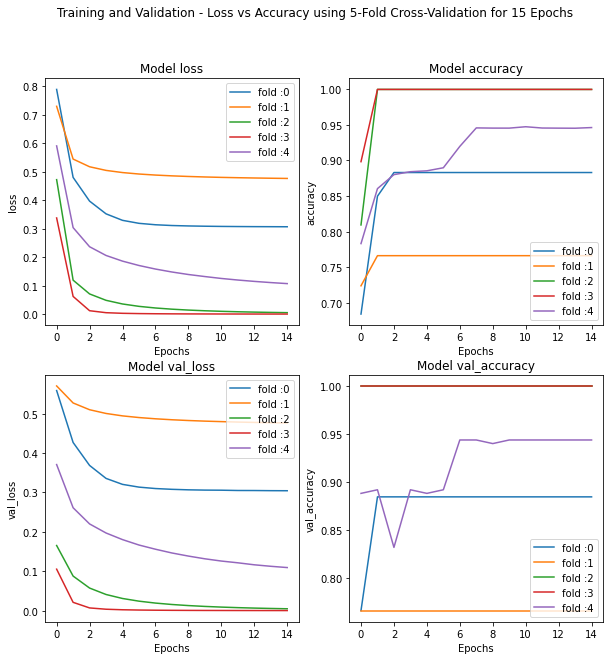

In [26]:
metrics = ['loss', 'accuracy','val_loss','val_accuracy']

# to plot the histories of data
fig=plt.figure(figsize = (10,10))

axes = fig.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2)
axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)


i=1
for i,metric in enumerate(metrics):   
    for history in histories:     
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_title("Model "+ metrics[i])
        axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history.history[metric])
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xlabel("Epochs")
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_ylabel(metrics[i])
        axes[(i+2)//2 - 1, 1 - (i+1)%2].legend(["fold :"+ str(i) for i in range(len(histories))])
       
       # axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
        #                                        np.arange(max(history.history[metric]))
        #                                           )
plt.suptitle("Training and Validation - Loss vs Accuracy using 5-Fold Cross-Validation for 15 Epochs");     

In [27]:
# Class Prediction - Testing the model using X_test -XT and storing the output in y_pred i.e predict_x
predict_x=model.predict(XT_sel)
#predict_x
# inverse one hot encoder
pred_inv=enc.inverse_transform(predict_x)
#pred_inv
# inverse label encoder
pred_classes=np.ravel(pred_inv)
predictions=encoder.inverse_transform(pred_classes)
print("Sample predictions:")
print("------- Predicted Classified Labels --------\n ",predictions[0:20])
print("-------- Actual Labels ----\n ",YT[0:20])


Sample predictions:
------- Predicted Classified Labels --------
  [1 1 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-------- Actual Labels ----
  [1 1 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, roc_auc_score

In [29]:
# Performance Measures of the Model
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(YT, predictions)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(YT, predictions,average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(YT, predictions,average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(YT, predictions,average='weighted')
print('F1 score: %f' % f1)
 
# kappa
#kappa = cohen_kappa_score(YT, predictions)
#print('Cohens kappa: %f' % kappa)

# ROC AUC
# test_data array is only one-dimensional, so change to
#YT = np.argmax(YT, axis=0)
#auc = roc_auc_score(YT, predictions,multi_class='ovo',average='weighted')
#print('ROC AUC: %f' % auc)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


Confusion Matrix allows us to measure Recall, Precision,
Accuracy and AUC-ROC curve are the metrics to measure the performance of
the model.

In [30]:
# Creating  a confusion matrix,which compares the y_test and y_predictions
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(YT,predictions, labels=[1,2,3])
#cm

In [31]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['eMBB Slice-1','mMTC Slice-2','URLLC Slice -3'], 
                     columns = ['eMBB Slice-1','mMTC Slice-2','URLLC Slice -3'])

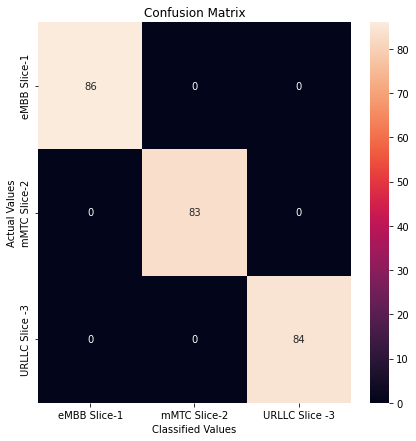

In [32]:
import seaborn as sns
#Plotting the confusion matrix
plt.figure(figsize=(7,7))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Classified Values')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(YT,predictions, target_names=['eMBB Slice-1', 'mMTC Slice-2', 'URLLC Slice -3']))


Classification Report

                precision    recall  f1-score   support

  eMBB Slice-1       1.00      1.00      1.00        86
  mMTC Slice-2       1.00      1.00      1.00        83
URLLC Slice -3       1.00      1.00      1.00        84

      accuracy                           1.00       253
     macro avg       1.00      1.00      1.00       253
  weighted avg       1.00      1.00      1.00       253



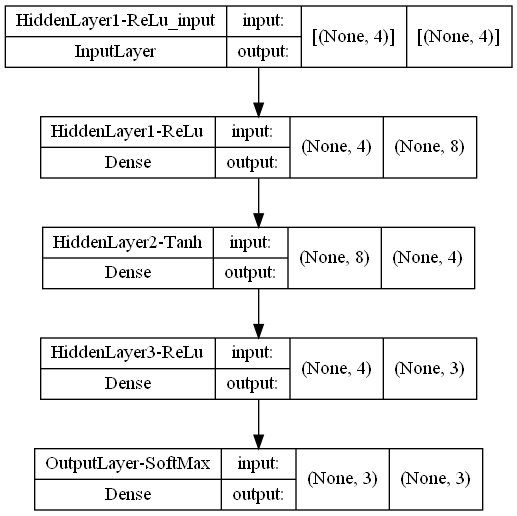

In [34]:
# Plot model summary
plot_model(model,show_shapes=True)

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1-ReLu (Dense)   (None, 8)                 40        
                                                                 
 HiddenLayer2-Tanh (Dense)   (None, 4)                 36        
                                                                 
 HiddenLayer3-ReLu (Dense)   (None, 3)                 15        
                                                                 
 OutputLayer-SoftMax (Dense)  (None, 3)                12        
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Evaluate the restored model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Testing Accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(XT_sel).shape)

395/395 - 0s - loss: 0.1058 - accuracy: 0.9480 - 400ms/epoch - 1ms/step
Testing Accuracy: 94.80%
(253, 3)


Reference:
    A. Thantharate, R. Paropkari, V. Walunj, and C. Beard, “Deepslice: A deep learning approach towards an efficient and reliable network slicing in 5g networks,” in 2019 IEEE 10th Annual Ubiquitous Computing,Electronics & Mobile Communication Conference (UEMCON). IEEE, 2019, pp. 0762–0767.